In [1]:
!pip install --upgrade --force-reinstall scipy ISLP pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 381.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.9 MB/s eta 0:00:00


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import DataLoader, TensorDataset

from torchmetrics import (MeanAbsoluteError, R2Score)
from torchsummary import summary

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar

from ISLP.torch import (SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers)

INFO:lightning_fabric.utilities.seed:Seed set to 0


In [4]:
# Read Bitcoin daily price file
btc_data = pd.read_csv('coin_Bitcoin.csv', usecols = ['Date', 'Close'])

# Filter Dates
btc_data = btc_data[(btc_data['Date']>='2015-04-26') & (btc_data['Date']<='2025-03-31')]

# Calculate Daily Returns
btc_data['ret'] = btc_data['Close'].pct_change() * 100

# Drop NaN values and reset index
btc_data.dropna(inplace=True)
btc_data.reset_index(inplace=True, drop=True)

btc_data

,Date,Close,ret
0,2015-04-27 23:59:59,229.285995,4.491639
1,2015-04-28 23:59:59,225.854996,-1.496384
2,2015-04-29 23:59:59,225.807999,-0.020809
3,2015-04-30 23:59:59,236.145004,4.577785
4,2015-05-01 23:59:59,232.078995,-1.721827
...,...,...,...
2258,2021-07-02 23:59:59,33897.048590,0.967860
2259,2021-07-03 23:59:59,34668.548402,2.276009
2260,2021-07-04 23:59:59,35287.779766,1.786147
2261,2021-07-05 23:59:59,33746.002456,-4.369154


## **Q1: CNN**

In [5]:
# Create rolling features and targets
def create_rolling_windows(data, days):
    lags = []
    target = []
    for i in range(len(data) - days):
        lags.append(data[i:i+days])
        target.append(data[i+days])
    return np.array(lags), np.array(target)

# Select target variable
y = btc_data['ret'].values

# Split into training data
test_size = 500
train_data, test_data = y[:-test_size], y[-test_size:]

# Select number of days / features
days = 5
X_train, y_train = create_rolling_windows(train_data, days)
X_test, y_test = create_rolling_windows(test_data, days)

# Reshape the input data for the CNN
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print (f'Training data shape: {X_train.shape}')
print (f'Training target shape: {y_train.shape}')
print (f'Test data shape: {X_test.shape}')
print (f'Test target shape: {y_test.shape}')

Training data shape: (1758, 1, 5)
Training target shape: (1758,)
Test data shape: (495, 1, 5)
Test target shape: (495,)


## Transform the training data into a form accessible to torch.

In [6]:
# Training tensor
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(y_train.astype(np.float32))
btc_train = TensorDataset(X_train_t, Y_train_t)

# Test tensor
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(y_test.astype(np.float32))
btc_test = TensorDataset(X_test_t, Y_test_t)

# Determine the recommended number of worker processes based on the system's capabilities
max_num_workers = rec_num_workers()

## Confirm shape of batches

In [7]:
# prepare the dataset by organizing it into training, validation, and test sets,
# and defining how the data will be fed into the model during training and evaluation.
btc_dm = SimpleDataModule(btc_train, btc_test, batch_size=128,
                          num_workers=min(4, max_num_workers),
                          validation=int(X_train.shape[0] * 0.2))

# Check the shape of the batch in the dataloader
for idx, (X_ ,Y_) in enumerate(btc_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1: # stop after 2 batches
        break

X:  torch.Size([128, 1, 5])
Y:  torch.Size([128])
X:  torch.Size([128, 1, 5])
Y:  torch.Size([128])


## Set up the NN structure

In [8]:
class BitcoinModel(nn.Module):
    def __init__(self, days, in_channel, out_channel, kernel_size, pool_size):
        super().__init__()

        self.conv = nn.Conv1d(in_channels = in_channel, out_channels = out_channel,
                               kernel_size = kernel_size)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size = pool_size)

        # Length after convolution
        conv_output_length = days - kernel_size + 1

        # Length after max pooling
        pooled_length = conv_output_length // pool_size

        # Flattened dimension
        self.flatten_dim = out_channel * pooled_length

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_dim, 50)
        self.fc2 = nn.Linear(50, 1)  # Output layer

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.squeeze(-1)

## Instantiate CNN

In [9]:
# Define network dimensions
days = 5
in_channel = 1
out_channel = 64
kernel_size = 3
pool_size = 2

# Instantiate the network
btc_model = BitcoinModel(days, in_channel, out_channel, kernel_size, pool_size)

# Move the model to the GPU
if torch.cuda.is_available():
    btc_model.cuda()  # Move model to GPU

summary(btc_model, input_size=(X_train.shape[1],X_train.shape[2]), batch_size=X_train.shape[0])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [1758, 64, 3]             256
              ReLU-2              [1758, 64, 3]               0
         MaxPool1d-3              [1758, 64, 1]               0
           Flatten-4                 [1758, 64]               0
            Linear-5                 [1758, 50]           3,250
              ReLU-6                 [1758, 50]               0
            Linear-7                  [1758, 1]              51
Total params: 3,557
Trainable params: 3,557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 8.22
Params size (MB): 0.01
Estimated Total Size (MB): 8.27
----------------------------------------------------------------


## Fit the CNN

In [10]:
# Set the learning rate
learning_rate = 0.001

# Configure Optimizer and Model Module
btc_optimizer = RMSprop(btc_model.parameters(), lr=learning_rate)
btc_module = SimpleModule.regression(btc_model, metrics={'mae':MeanAbsoluteError()}, optimizer=btc_optimizer)

# Set up Logging and progress bar
progress_bar = TQDMProgressBar(refresh_rate=5, process_position=0)

btc_trainer = Trainer(deterministic = True, max_epochs = 100, enable_progress_bar = True,
                      callbacks = [ErrorTracker(), progress_bar])

btc_trainer.fit(btc_module, datamodule = btc_dm)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | BitcoinModel | 3.6 K  | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## **Q2: Report Test MAE**

In [11]:
btc_trainer.test(btc_module, datamodule=btc_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     19.78390121459961     │
│         test_mae          │     2.952348470687866     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 19.78390121459961, 'test_mae': 2.952348470687866}]

In [12]:
btc_data['ret'].describe()

,ret
count,2263.000000
mean,0.300519
std,3.909800
min,-37.169541
25%,-1.169949
50%,0.214507
75%,1.790962
max,25.247169


Given the distribution of Bitcoin daily returns in the dataset (mean: 0.30%, std: 3.91%, and a wide range from -37.17% to +25.25%), CNN'S test MAE of 2.95% is reasonably good. This means that on average, the one-day-ahead predictions deviate by 2.9 percentage points from the actual return, which is lower than the standard deviation of the returns. However, there is still room for improvement with potentially deeper features and methods, like LSTMs and GRUs.

Predicting: |          | 0/? [00:00<?, ?it/s]

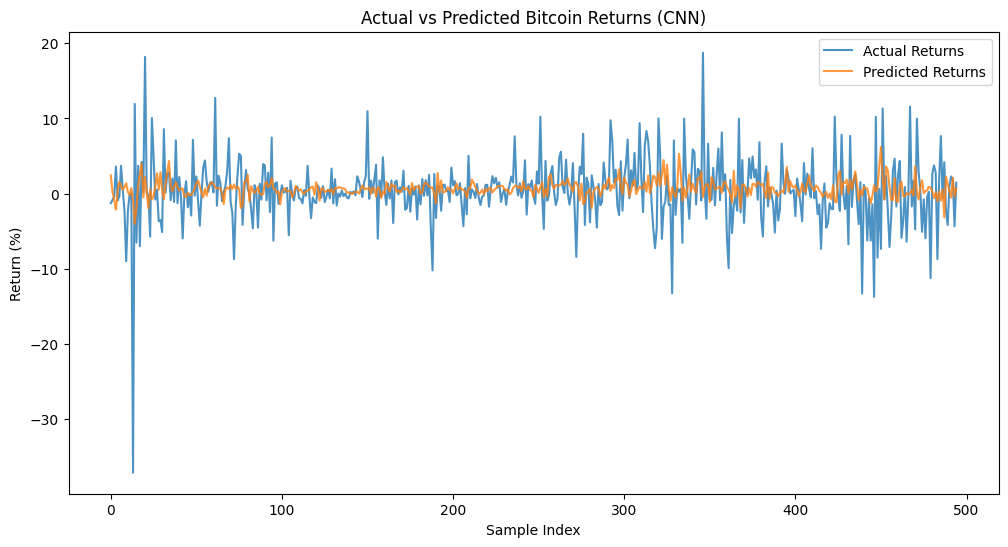

In [65]:
acts_cnn, preds_cnn = btc_trainer.predict(btc_module, datamodule=btc_dm)[0]
plt.figure(figsize=(12, 6))
plt.plot(acts_cnn, label='Actual Returns', alpha=0.8)
plt.plot(preds_cnn, label='Predicted Returns', alpha=0.8)
plt.xlabel('Sample Index')
plt.ylabel('Return (%)')
plt.title('Actual vs Predicted Bitcoin Returns (CNN)')
plt.legend()
plt.show()

## **Q3: Model Architecture**

To design the 1D CNN, I experimented with different architectures and hyperparameters to optimize test performance. My final model uses one convolutional layer with 64 filters and a kernel size of 3 (considering the small input size of 5 days), followed by ReLU activation, max pooling (kernel size 2) to reduce dimensionality, and two fully connected layers (50 units and 1 output). I selected this structure after testing various configurations, including adding a second convolutional layer to extract higher-order features. However, the deeper model overfit the training data and yielded higher test MAE due to the bias-variance tradeoff. I also tuned hyperparameters such as number of filters (32, 64, 128), kernel size (2,3), the batch size (32, 64, 128, 256), and number of epochs (50, 100, 150) through trial and error. I ultimately picked the model that performed best on unseen data.

# **Question 4: RNNs**

## Reshape data for RNN input into a 3-dimensional structure

In [13]:
# The first dimension is the number of samples
# The second dimension is the number of time steps (5 in this case)
# The third dimension is the number of features (1 in this case)

X_train_rnn_t = X_train_t.reshape(X_train_t.shape[0], X_train_t.shape[2], X_train_t.shape[1])
X_test_rnn_t = X_test_t.reshape(X_test_t.shape[0], X_test_t.shape[2], X_test_t.shape[1])
btc_train_rnn = TensorDataset(X_train_rnn_t, Y_train_t)
btc_test_rnn = TensorDataset(X_test_rnn_t, Y_test_t)

## Confirm shape of batches

In [14]:
# prepare the dataset by organizing it into training, validation, and test sets,
# and defining how the data will be fed into the model during training and evaluation.
btc_rnn_dm = SimpleDataModule(btc_train_rnn, btc_test_rnn, batch_size=128,
                              num_workers=min(4, max_num_workers),
                              validation=int(X_train.shape[0] * 0.2))

# Check the shape of the batch in the dataloader
for idx, (X_ ,Y_) in enumerate(btc_rnn_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1: # stop after 2 batches
        break

X:  torch.Size([128, 5, 1])
Y:  torch.Size([128])
X:  torch.Size([128, 5, 1])
Y:  torch.Size([128])


## Set up 2-layer GRU model

In [15]:
class btc_GRU_Model(nn.Module):
    def __init__(self, hidden_units, dropout_pc):
        super(btc_GRU_Model, self).__init__()
        self.gru = nn.GRU(1, hidden_units, num_layers=2, dropout=dropout_pc, batch_first=True)  # GRU layer with 2 layers, 12 hidden units each
        self.dense = nn.Linear(hidden_units, 1)  # Linear layer for output
        self.dropout = nn.Dropout(dropout_pc)  # Dropout for regularization

    def forward(self, x):
        # Pass input through GRU
        val, h_n = self.gru(x)
        # Apply linear layer to the last GRU output
        val = self.dense(self.dropout(val[:, -1]))
        return torch.flatten(val)  # Flatten output

## Instantiate GRU

In [16]:
hidden_units = 24
dropout_pc = 0.3

# Create an instance of the model
btc_gru_model = btc_GRU_Model(hidden_units, dropout_pc)

# Move the model to the GPU
if torch.cuda.is_available():
    btc_gru_model.cuda()  # Move model to GPU

summary(btc_gru_model, input_size=(X_train_rnn_t.shape[1],X_train_rnn_t.shape[2]), batch_size=X_train_rnn_t.shape[0])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 5, 24], [-1, 2, 24]]               0
           Dropout-2                 [1758, 24]               0
            Linear-3                  [1758, 1]              25
Total params: 25
Trainable params: 25
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.38
Params size (MB): 0.00
Estimated Total Size (MB): 0.41
----------------------------------------------------------------


In [17]:
# Print model summary
total_params = sum(p.numel() for p in btc_gru_model.parameters())
print(total_params)

5569


## Fit GRU

In [18]:
# Configure Optimizer and Model Module
btc_rnn_optimizer = RMSprop(btc_gru_model.parameters(), lr=learning_rate)
btc_rnn_module = SimpleModule.regression(btc_gru_model, metrics={'mae':MeanAbsoluteError()},
                                          optimizer=btc_rnn_optimizer)

btc_rnn_trainer = Trainer(deterministic = True, max_epochs = 100, enable_progress_bar = True,
                  callbacks = [ErrorTracker(), progress_bar])

btc_rnn_trainer.fit(btc_rnn_module, datamodule = btc_rnn_dm)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | btc_GRU_Model | 5.6 K  | train
1 | loss  | MSELoss       | 0      | train
------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## **Q5: Report Test MAE**

In [20]:
btc_rnn_trainer.test(btc_rnn_module, datamodule=btc_rnn_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    18.326162338256836     │
│         test_mae          │    2.8564341068267822     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 18.326162338256836, 'test_mae': 2.8564341068267822}]

Again, given the high standard deviation and presence of extreme values in the BTC daily return distribution, an average prediction error of 2.85% is a reasonable outcome. This suggests that the GRU model is effective at learning short-term temporal dependencies in the data, although the presence of noise and sharp return moves still hurts the overall predictive accuracy. Overall, again the results show that the GRU can provide informative forecasts for one-day-ahead returns.

## **Q6: Model Architecture**

The final GRU model I implemented consists of two stacked GRU layers with 24 hidden units each, followed by a dropout layer with a 30% rate for regularization and a fully connected linear layer to output the one-day-ahead return prediction. This architecture was designed to capture short-term temporal patterns in the return series while maintaining model simplicity. I experimented with various hyperparameter combinations, including different numbers of hidden units (16, 32, 64) and dropout rates (0.1 - 0.5). The chosen configuration achieved the lowest validation error, while helping to reduce overfitting on the noisy return data.

# **Q7: Comparison**

Both models demonstrate reasonable predictive power given the noisy nature of Bitcoin returns. The GRU model achieved a slightly lower test MAE (2.85%) compared to the 1D CNN (2.893%), but the performance difference is small. This is likely due to the high volatility of the data and limited input length.  Overall, the small improvement suggests that the GRU was better able to capture temporal dependencies in the return data.  

Predicting: |          | 0/? [00:00<?, ?it/s]

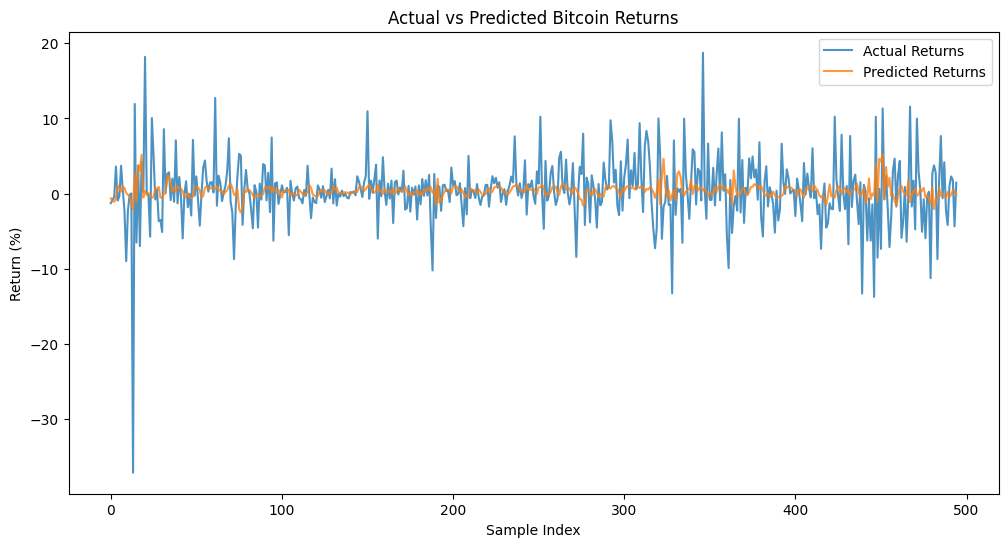

In [55]:
acts_gru, preds_gru = btc_rnn_trainer.predict(btc_rnn_module, datamodule=btc_rnn_dm)[0]
plt.figure(figsize=(12, 6))
plt.plot(acts_gru, label='Actual Returns', alpha=0.8)
plt.plot(preds_gru, label='Predicted Returns', alpha=0.8)
plt.xlabel('Sample Index')
plt.ylabel('Return (%)')
plt.title('Actual vs Predicted Bitcoin Returns (GRU)')
plt.legend()
plt.show()